## Import required packages

In [2]:
import argparse
import torch
from PIL import Image
import pandas as pd
import os
from scipy.io import loadmat
from torch.utils import data
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision.io import read_image
from torchvision import datasets, models, transforms, utils
import numpy as np
import cv2
import torch.nn as nn
import matplotlib.pyplot as plt
import random
# !pip install ipywidgets widgetsnbextension
# !jupyter nbextension enable --py widgetsnbextension

## Create Parser

In [86]:
parser = argparse.ArgumentParser(description='PyTorch Pineapple Image Classification')
parser.add_argument('--model', default='ResNet18', type=str)
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=50, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=32, type=int,
                    metavar='N')
parser.add_argument('--wd', '--weight-decay', default=1e-5, type=float,
                    metavar='W', help='weight decay (default: 1e-5)',
                    dest='weight_decay')
parser.add_argument('--save-freq', default=10, type=int,
                    metavar='N', help='Save trained model every x batches')
parser.add_argument('--epoch-size', default=31052, type=int,
                    help='size of training set to use (total default size:55,270, size of fingerprint dataset size)')
parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
parser.add_argument('--patience', default=10, type=int,
                    help="number of times of patience of model improvement")
    
#args = parser.parse_args() # for command line
args = parser.parse_args(args=['--model', 'ResNet50', '-b', '128', '--wd', '0',  '--epochs', '30']) # for jupyter notebook

## Create fingerprint dataset class

In [87]:
# 2023-3-12 custom dataset created by Allen LIN

class fingerprintDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.targets = self.img_labels.iloc[:, 1] # label of the dataset
        self.target_transform = target_transform
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[0, 0])
        image = cv2.imread(img_path)
        self.data = np.empty((len(self.img_labels), *image.shape), dtype=np.uint8)
        for i in range(len(self.img_labels)):
            self.data[i] = image
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = cv2.imread(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    def __len__(self):
        return len(self.img_labels)

## 實例化類別

tensor([[[ 0.2644,  0.1498,  0.1498,  ..., -1.2347, -1.2347, -1.2347],
         [ 0.1785,  0.0066,  0.4172,  ..., -1.2347, -1.2347, -1.2347],
         [ 0.1785,  0.2835,  1.2001,  ..., -1.2347, -1.2347, -1.2347],
         ...,
         [-1.2252, -1.2347, -1.2252,  ..., -1.2347, -1.2347, -1.2347],
         [-1.2347, -1.2347, -1.2347,  ..., -1.2347, -1.2347, -1.2347],
         [-1.2347, -1.2347, -1.2347,  ..., -1.2347, -1.2347, -1.2347]],

        [[ 0.2644,  0.1498,  0.1498,  ..., -1.2347, -1.2347, -1.2347],
         [ 0.1785,  0.0066,  0.4172,  ..., -1.2347, -1.2347, -1.2347],
         [ 0.1785,  0.2835,  1.2001,  ..., -1.2347, -1.2347, -1.2347],
         ...,
         [-1.2252, -1.2347, -1.2252,  ..., -1.2347, -1.2347, -1.2347],
         [-1.2347, -1.2347, -1.2347,  ..., -1.2347, -1.2347, -1.2347],
         [-1.2347, -1.2347, -1.2347,  ..., -1.2347, -1.2347, -1.2347]],

        [[ 0.2644,  0.1498,  0.1498,  ..., -1.2347, -1.2347, -1.2347],
         [ 0.1785,  0.0066,  0.4172,  ..., -1

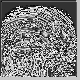

In [88]:
def show_pic(img):
    # display image 
    transform = transforms.ToPILImage()
    img = transform(img)
    img.show()
    

# Create train/valid transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(), # to PIL format
    transforms.Resize((80, 80)),
    #transforms.RandomCrop((224, 224)),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.5071, 0.5071], std=[0.4107, 0.4107, 0.4107]), # image = (image-mean) / std
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.ToPILImage(), # to PIL format
    transforms.Resize((80, 80)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.5071, 0.5071], std=[0.4107, 0.4107, 0.4107]), # image = (image-mean) / std
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset
training_annotations_file = os.path.join("kaggle_fingerprint", "kaggle_training_fingerprint_annotations.csv")
validation_annotations_file = os.path.join("kaggle_fingerprint", "kaggle_validation_fingerprint_annotations.csv")
img_dir = os.path.join("kaggle_fingerprint", "SOCOFing", "All")

train_set = fingerprintDataset(training_annotations_file, img_dir, transform=train_transform)
valid_set = fingerprintDataset(validation_annotations_file, img_dir, transform=valid_transform)

first_img = train_set[0]
img, label = first_img
print(img)
print(f'img_mean: {img.mean(dim=[1,2])}')
print(f'img_std: {img.std(dim=[1,2])}')
print(img.shape)
show_pic(img)


# Create train/valid loaders
train_loader = DataLoader(
    dataset=train_set, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
test_loader = DataLoader(
    dataset=valid_set, batch_size=args.batch_size, shuffle=False, num_workers=args.workers)

## 定義類神經網路模型

In [12]:
# using ResNet50 pre-trained model
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()

        # Define proportion or neurons to dropout
#         self.dropout = nn.Dropout(0.2)
    
    
        # 載入 ResNet18 類神經網路結構
        self.model = models.resnet50()

        # 鎖定 ResNet18 預訓練模型參數
        # for param in self.model.parameters():
        #   param.requires_grad = False
        
        # 修改輸出層輸出數量
        self.model.fc = nn.Linear(2048, 600)
         # Modify the output layer

    def forward(self, x):
        x = self.model(x)
        return x

In [91]:
# 若 CUDA 環境可用，則使用 GPU 計算，否則使用 CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# 建立類神經網路模型，並放置於 GPU 或 CPU 上
if args.model == "ResNet18":
    model = ResNet18().to(device)
elif args.model == "ResNet50":
    model = ResNet50().to(device)
else:
    print("no defined such model")
print(model)

Using cuda device
ResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [92]:
# 損失函數
loss_fn = nn.CrossEntropyLoss()

# 學習優化器
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=args.weight_decay)

# 訓練模型
def train(dataloader, model, loss_fn, optimizer):
    # 資料總筆數
    size = len(dataloader.dataset)
    
     # 批次數量
    num_batches = len(dataloader)
    
    # 定義平均的 loss 與 Acc
    total_loss, total_correct = 0, 0
    
    # 將模型設定為訓練模式
    model.train()

    # 批次讀取資料進行訓練
    for batch, (X, y) in enumerate(dataloader):
        # 將資料放置於 GPU 或 CPU
        X, y = X.to(device), y.to(device)

        pred = model(X)         # 計算預測值
        loss = loss_fn(pred, y) # 計算損失值（loss）
        total_loss += loss.item()
        total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # 計算預測正確數量的加總值
        optimizer.zero_grad()   # 重設參數梯度（gradient）
        loss.backward()         # 反向傳播（backpropagation）
        optimizer.step()        # 更新參數

        # 輸出訓練過程資訊
        if batch % args.save_freq == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return total_loss/num_batches, 100*total_correct/size

In [93]:
# 測試模型
def test(dataloader, model, loss_fn):
    # 資料總筆數
    size = len(dataloader.dataset)

    # 批次數量
    num_batches = len(dataloader)

    # 將模型設定為驗證模式
    model.eval()

    # 初始化數值
    test_loss, correct = 0, 0

    # 驗證模型準確度
    with torch.no_grad():  # 不要計算參數梯度
        for X, y in dataloader:
            # 將資料放置於 GPU 或 CPU
            X, y = X.to(device), y.to(device)

            # 計算預測值
            pred = model(X)

            # 計算損失值的加總值
            test_loss += loss_fn(pred, y).item()

            # 計算預測正確數量的加總值
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # 計算平均損失值與正確率
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, 100*correct

In [94]:
def print_loss(train_loss, test_loss):
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Loss")
    plt.plot(train_loss,  label = "Training") # training loss curve
    plt.plot(test_loss,  label = "Validation") # training loss curve
    plt.legend(loc = 'upper left')
    fig = plt.gcf() # get current figure
    plt.show()
    return fig
    
def print_acc(train_acc, test_acc):
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    plt.title("Accuracy")
    plt.plot(train_acc,  label = "Training") # training loss curve
    plt.plot(test_acc,  label = "Validation") # training loss curve
    plt.legend(loc = 'upper left')
    fig = plt.gcf() # get current figure
    plt.show()
    return fig
    
def save_result_fig(args, name, version=0):
    result_path = os.path.join('results', "Allen's Result", "SOCOFing_Fingerprint", "Supervised", args.model,
                                  'epochsize_{}-bsize_{}-tepochs_{}_{}_{}_Fig.jpg'.format(args.epoch_size, args.batch_size, args.epochs, name, version))
    if os.path.exists(result_path):
        return save_result_fig(args, name, version+1)
    else:    
        return result_path

Namespace(batch_size=128, epoch_size=31052, epochs=30, model='ResNet50', patience=10, save_freq=10, save_model=False, weight_decay=0.0, workers=4)
Epoch 1/30
-------------------------------
loss: 6.596277  [    0/31051]
loss: 6.469209  [ 1280/31051]
loss: 6.470075  [ 2560/31051]
loss: 6.414942  [ 3840/31051]
loss: 6.510921  [ 5120/31051]
loss: 6.533876  [ 6400/31051]
loss: 6.475951  [ 7680/31051]
loss: 6.492324  [ 8960/31051]
loss: 6.443741  [10240/31051]
loss: 6.490557  [11520/31051]
loss: 6.476557  [12800/31051]
loss: 6.453302  [14080/31051]
loss: 6.478244  [15360/31051]
loss: 6.441368  [16640/31051]
loss: 6.452325  [17920/31051]
loss: 6.436250  [19200/31051]
loss: 6.394242  [20480/31051]
loss: 6.444988  [21760/31051]
loss: 6.445707  [23040/31051]
loss: 6.457081  [24320/31051]
loss: 6.448982  [25600/31051]
loss: 6.418083  [26880/31051]
loss: 6.414844  [28160/31051]
loss: 6.424255  [29440/31051]
loss: 6.488083  [30720/31051]
Test Error: 
 Accuracy: 0.2%, Avg loss: 6.430622 

Best mode

loss: 4.847453  [ 5120/31051]
loss: 5.030594  [ 6400/31051]
loss: 4.954031  [ 7680/31051]
loss: 5.052532  [ 8960/31051]
loss: 4.813178  [10240/31051]
loss: 5.142103  [11520/31051]
loss: 4.647437  [12800/31051]
loss: 4.619592  [14080/31051]
loss: 4.557776  [15360/31051]
loss: 4.804621  [16640/31051]
loss: 4.701351  [17920/31051]
loss: 4.668475  [19200/31051]
loss: 4.728055  [20480/31051]
loss: 4.831257  [21760/31051]
loss: 4.802412  [23040/31051]
loss: 4.595683  [24320/31051]
loss: 4.812661  [25600/31051]
loss: 4.647110  [26880/31051]
loss: 4.618631  [28160/31051]
loss: 4.524992  [29440/31051]
loss: 4.735170  [30720/31051]
Test Error: 
 Accuracy: 15.5%, Avg loss: 4.843607 

Best model found at epoch 10, saving model
Epoch 11/30
-------------------------------
loss: 4.433192  [    0/31051]
loss: 4.554015  [ 1280/31051]
loss: 4.442409  [ 2560/31051]
loss: 4.719249  [ 3840/31051]
loss: 4.652411  [ 5120/31051]
loss: 4.613359  [ 6400/31051]
loss: 4.624835  [ 7680/31051]
loss: 4.484124  [ 896

loss: 1.638508  [14080/31051]
loss: 1.476824  [15360/31051]
loss: 1.629038  [16640/31051]
loss: 1.404640  [17920/31051]
loss: 1.252375  [19200/31051]
loss: 1.411517  [20480/31051]
loss: 1.555622  [21760/31051]
loss: 1.302993  [23040/31051]
loss: 1.451870  [24320/31051]
loss: 1.262340  [25600/31051]
loss: 1.334925  [26880/31051]
loss: 1.366959  [28160/31051]
loss: 1.385189  [29440/31051]
loss: 1.196281  [30720/31051]
Test Error: 
 Accuracy: 73.1%, Avg loss: 1.908192 

Best model found at epoch 19, saving model
Epoch 20/30
-------------------------------
loss: 1.226639  [    0/31051]
loss: 1.089104  [ 1280/31051]
loss: 1.077794  [ 2560/31051]
loss: 0.991874  [ 3840/31051]
loss: 1.125876  [ 5120/31051]
loss: 1.070386  [ 6400/31051]
loss: 0.937975  [ 7680/31051]
loss: 1.489253  [ 8960/31051]
loss: 1.416145  [10240/31051]
loss: 1.050686  [11520/31051]
loss: 0.923448  [12800/31051]
loss: 0.939268  [14080/31051]
loss: 1.012878  [15360/31051]
loss: 0.950223  [16640/31051]
loss: 1.018548  [1792

loss: 0.159066  [28160/31051]
loss: 0.100679  [29440/31051]
loss: 0.076455  [30720/31051]
Test Error: 
 Accuracy: 93.6%, Avg loss: 0.525125 

Epoch 29/30
-------------------------------
loss: 0.138043  [    0/31051]
loss: 0.099407  [ 1280/31051]
loss: 0.078416  [ 2560/31051]
loss: 0.095888  [ 3840/31051]
loss: 0.092712  [ 5120/31051]
loss: 0.088490  [ 6400/31051]
loss: 0.070912  [ 7680/31051]
loss: 0.073824  [ 8960/31051]
loss: 0.115902  [10240/31051]
loss: 0.098629  [11520/31051]
loss: 0.094468  [12800/31051]
loss: 0.129446  [14080/31051]
loss: 0.136754  [15360/31051]
loss: 0.104963  [16640/31051]
loss: 0.097234  [17920/31051]
loss: 0.078826  [19200/31051]
loss: 0.233459  [20480/31051]
loss: 0.109972  [21760/31051]
loss: 0.172139  [23040/31051]
loss: 0.103859  [24320/31051]
loss: 0.117974  [25600/31051]
loss: 0.185068  [26880/31051]
loss: 0.121893  [28160/31051]
loss: 0.058919  [29440/31051]
loss: 0.095530  [30720/31051]
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.422718 

Best model f

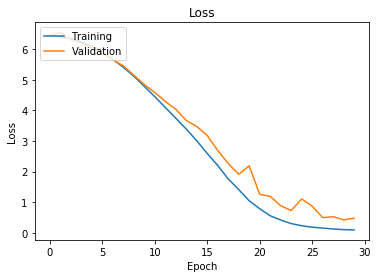

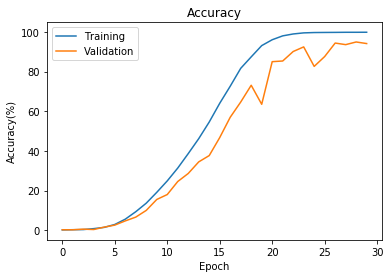

In [95]:
avg_loss, avg_acc = 0, 0
best_acc, stale = 0, 0
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# # 開始訓練模型
print(args)
for t in range(args.epochs):
    print(f"Epoch {t+1}/{args.epochs}\n-------------------------------")
    avg_loss, avg_acc = train(train_loader, model, loss_fn, optimizer)
    train_loss_list.append(avg_loss)
    train_acc_list.append(avg_acc)
    avg_loss, avg_acc = test(test_loader, model, loss_fn)
    test_loss_list.append(avg_loss)
    test_acc_list.append(avg_acc)
    if avg_acc > best_acc:
        print(f"Best model found at epoch {t+1}, saving model")
        path = os.path.join("model", "sup", args.model, "supervised_fingerprint_model.pt")
        torch.save(model.state_dict(), path)
        best_acc = avg_acc
        stale = 0
    else:
        stale += 1
        if stale > args.patience:
            print(f"No improvment {args.patience} consecutive epochs, early stopping")
            break

print("完成！")
print(f'Training Avg. Accuracy: {np.mean(train_acc_list)}')
print(f'Validation Avg. Accuracy: {np.mean(test_acc_list)}')

fig_loss = print_loss(train_loss_list, test_loss_list)
fig_loss_path = save_result_fig(args, "Loss")
fig_acc = print_acc(train_acc_list, test_acc_list)
fig_acc_path = save_result_fig(args, "Acc")
 # 將訓練結果存起來
fig_loss.savefig(fig_loss_path, bbox_inches='tight')
fig_acc.savefig(fig_acc_path, bbox_inches='tight')

## Prediction of fingerprint (Testing)

In [35]:
# load testing dataset
testing_annotations_file = os.path.join("kaggle_fingerprint", "kaggle_testing_fingerprint_annotations.csv")
img_dir = os.path.join("kaggle_fingerprint", "SOCOFing", "All")
data = []
fingerprints = []
img_labels = pd.read_csv(testing_annotations_file, encoding="unicode_escape")

test_transform = transforms.Compose([
    transforms.ToPILImage(), # to PIL format
    transforms.Resize((80, 80)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.5071, 0.5071], std=[0.4107, 0.4107, 0.4107]), # image = (image-mean) / std
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for idx in range(len(img_labels)):
    img_path = os.path.join(img_dir, img_labels.iloc[idx, 0])
    directory, filename = os.path.split(img_path)
    fingerprint_id = filename.split('__')[0]
    #print(fingerprint_id)
    fingerprints.append(fingerprint_id)
    image_data = cv2.imread(img_path)
    image_data = test_transform(image_data)
    #print(image_data.shape)
    data.append(image_data)

data = np.stack(data, axis=0)
#data = np.array(data)
data = np.transpose(data, (0, 2, 3, 1))
print(data.shape)

(3916, 80, 80, 3)


In [36]:
# load saved model to predict
pred = []
fingprints = []
PATH = os.path.join("model", "sup", "ResNet50", "supervised_fingerprint_model.pt")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = ResNet50().to(device)
model.load_state_dict(torch.load(PATH))
# Set model to evaluation mode
model.eval()
for i in range(data.shape[0]):
    xitem = data[i, :, :, :]
    #xitem=Image.fromarray(np.uint8(xitem))
    xitem = transforms.ToTensor()(xitem)
    input1 = xitem.unsqueeze(0)
    outputs = model(input1.to(device))
    preds = outputs.argmax(1)
    pred.append(preds.item())

Using cuda device


In [37]:
# save the predicted result into csv file
import csv
dest_path = "fingerprint_prediction.csv"
data_list = [["groundtruth", "predicted"]]
for i in range(len(fingerprints)):
    data = []
    data.append(fingerprints[i])
    data.append(pred[i])
    data_list.append(data)
with open(dest_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerows(data_list)

In [44]:
# print the accuracy of test result
file_path = "fingerprint_prediction.csv"
prediction_file = pd.read_csv(file_path, encoding="unicode_escape")
correct = 0

for i in range(len(prediction_file)):
    if prediction_file.iloc[i, 0] == prediction_file.iloc[i, 1]:
        correct += 1

print(f'(correct/total) {correct}/{len(prediction_file)}: {correct/len(prediction_file)}')

(correct/total) 3726/3916: 0.9514811031664965
